#Import necessary libraries

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=af3820e9238221e0b1a72ecb5ae65c52f0427a5e55e28c49d69b0f1767c8d2ab
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, mean, count, col, lit, desc, format_number, format_string, expr
from pyspark.sql.functions import dayofweek, year, date_format, month, round
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, unix_timestamp
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import first

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium

#Create Spark Session

In [3]:
spark = SparkSession.builder \
    .appName("PySparkMySQL") \
    .getOrCreate()

#Data Ingestion

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Loading the dataset
traffic_data = spark.read.parquet('/content/drive/MyDrive/chicagoTrafficData')

In [6]:
traffic_data.show(10)

+--------------------+----------+-----+-------+-----------+---------+------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|                time|segment_id|speed| street|from_street|to_street|length|hour|day_of_week|month|start_latitude|start_longitude| end_latitude| end_longitude|      start_location|        end_location|
+--------------------+----------+-----+-------+-----------+---------+------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|2018-03-02T17:50:...|       143|   24|Ashland|       47th|     51st|   0.5|  17|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6649598466,...|
|2018-03-02T18:01:...|       143|   20|Ashland|       47th|     51st|   0.5|  18|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.664959

#Data Preprocessing

In [7]:
# Convert format from miles per hour to km per hour, and from length in miles to length in km
traffic_data = (
    traffic_data
    .withColumn("speed",col("speed") * 1.60934)
    .withColumn("length",col("length") * 1.60934)
)

In [8]:
traffic_data.show(5)

+--------------------+----------+--------+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|                time|segment_id|   speed| street|from_street|to_street| length|hour|day_of_week|month|start_latitude|start_longitude| end_latitude| end_longitude|      start_location|        end_location|
+--------------------+----------+--------+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|2018-03-02T17:50:...|       143|38.62416|Ashland|       47th|     51st|0.80467|  17|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6649598466,...|
|2018-03-02T18:01:...|       143| 32.1868|Ashland|       47th|     51st|0.80467|  18|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559

In [11]:
# Take only two decimals from speed column
traffic_data = traffic_data.withColumn("speed", format_string("%.2f", col("speed").cast("float")))

In [10]:
traffic_data.show(5)

+--------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|                time|segment_id|speed| street|from_street|to_street| length|hour|day_of_week|month|start_latitude|start_longitude| end_latitude| end_longitude|      start_location|        end_location|
+--------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|2018-03-02T17:50:...|       143|38.62|Ashland|       47th|     51st|0.80467|  17|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6649598466,...|
|2018-03-02T18:01:...|       143|32.19|Ashland|       47th|     51st|0.80467|  18|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6

In [12]:
traffic_data.printSchema()

root
 |-- time: string (nullable = true)
 |-- segment_id: string (nullable = true)
 |-- speed: string (nullable = false)
 |-- street: string (nullable = true)
 |-- from_street: string (nullable = true)
 |-- to_street: string (nullable = true)
 |-- length: double (nullable = true)
 |-- hour: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: string (nullable = true)
 |-- start_latitude: string (nullable = true)
 |-- start_longitude: string (nullable = true)
 |-- end_latitude: string (nullable = true)
 |-- end_longitude: string (nullable = true)
 |-- start_location: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- end_location: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)



In [18]:
# Conversion of data types
traffic_data = (
    traffic_data
    .withColumn("time", col("time").cast("timestamp"))
    .withColumn("segment_id", col("segment_id").cast("int"))
    .withColumn("speed", col("speed").cast("float"))
    .withColumn("hour", col("hour").cast("int"))
    .withColumn("day_of_week", col("day_of_week").cast("int"))
    .withColumn("month", col("month").cast("int"))
    .withColumn("start_latitude", col("start_latitude").cast("double"))
    .withColumn("start_longitude", col("start_longitude").cast("double"))
    .withColumn("end_latitude", col("end_latitude").cast("double"))
    .withColumn("end_longitude", col("end_longitude").cast("double"))
)

In [19]:
traffic_data.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- segment_id: integer (nullable = true)
 |-- speed: float (nullable = true)
 |-- street: string (nullable = true)
 |-- from_street: string (nullable = true)
 |-- to_street: string (nullable = true)
 |-- length: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- start_latitude: double (nullable = true)
 |-- start_longitude: double (nullable = true)
 |-- end_latitude: double (nullable = true)
 |-- end_longitude: double (nullable = true)
 |-- start_location: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- end_location: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)



In [17]:
traffic_data.show()

+-------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|               time|segment_id|speed| street|from_street|to_street| length|hour|day_of_week|month|start_latitude|start_longitude| end_latitude| end_longitude|      start_location|        end_location|
+-------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+
|2018-03-02 17:50:21|       143|38.62|Ashland|       47th|     51st|0.80467|  17|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6649598466,...|
|2018-03-02 18:01:07|       143|32.19|Ashland|       47th|     51st|0.80467|  18|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.664959

CALCULATE THE AVERAGE TIME IT WILL TAKE TO GET FROM ONE POINT TO ANOTHER

In [20]:
# Create a new column named ‘estimated_time’ by dividing the ‘length’ of each segment by its corresponding ‘speed’.
traffic_data_time = (
    traffic_data
    .withColumn('estimated_time', round((col('length') / col('speed') * 60),2))
)

In [21]:
# Check for null values in 'estimated_time' column
traffic_data_time.select('estimated_time').filter(F.col('estimated_time').isNull() | F.isnan('estimated_time')).count()

1238

The missing entries are going to be replaced with the median value (50th percentile) of the ‘estimated_time’’ column. This imputation method ensures that the dataset remains representative and minimizes potential biases introduced by missing data.

In [22]:
# Calculate the 50th percentile of the 'estimated_time' column
percentile_50_value = (
    traffic_data_time
    .approxQuantile('estimated_time', [0.5], 0.001)[0]
)
# Fill null values with 50th percentile
traffic_data_time = (
    traffic_data_time
    .fillna(percentile_50_value, subset=['estimated_time'])
)

In [23]:
# Calculate the mean of the 'estimated_time' column
# mean_value = traffic_data_time.agg(F.mean('estimated_time')).collect()[0][0]

# Fill null values with mean
# traffic_data_time = traffic_data_time.fillna(mean_value, subset=['estimated_time'])


In [24]:
traffic_data_time.show(10)

+-------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+--------------+
|               time|segment_id|speed| street|from_street|to_street| length|hour|day_of_week|month|start_latitude|start_longitude| end_latitude| end_longitude|      start_location|        end_location|estimated_time|
+-------------------+----------+-----+-------+-----------+---------+-------+----+-----------+-----+--------------+---------------+-------------+--------------+--------------------+--------------------+--------------+
|2018-03-02 17:50:21|       143|38.62|Ashland|       47th|     51st|0.80467|  17|          6|    3| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|{[-87.6651559056,...|{[-87.6649598466,...|          1.25|
|2018-03-02 18:01:07|       143|32.19|Ashland|       47th|     51st|0.80467|  18|          6|    3| 41.8086055077| -87.6651559056|41

# Exploratory Data Analysis (EDA)

In [25]:
# 1. Descriptive Statistics:
traffic_data_time.describe(['speed', 'length', 'estimated_time']).show()

+-------+-----------------+-------------------+------------------+
|summary|            speed|             length|    estimated_time|
+-------+-----------------+-------------------+------------------+
|  count|          1881410|            1881410|           1881410|
|   mean|41.53971869814013| 0.8947982065603061|1.3333592677829442|
| stddev|8.495203555560462|0.26686825762982436|0.5523585829337506|
|    min|              0.0| 0.6437360000000001|              0.79|
|    max|            65.98|            1.60934|             59.98|
+-------+-----------------+-------------------+------------------+



array([[<Axes: title={'center': 'speed'}>]], dtype=object)

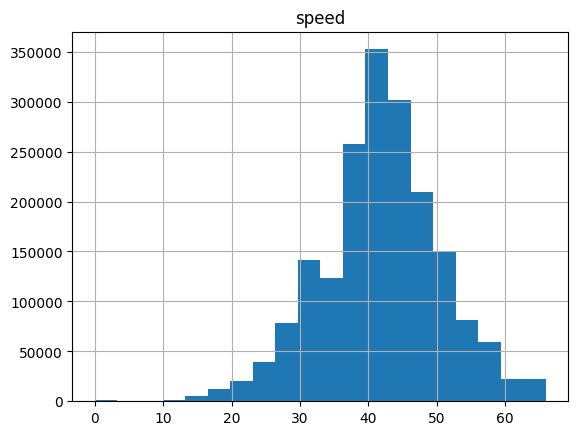

In [26]:
# 2. Speed Distribution:
traffic_data_time.select('speed').toPandas().hist(bins=20)

In [27]:
# 3. Relationship between Speed and Hour of the Day:
avg_speed_by_hour = traffic_data_time.groupBy('hour').agg(F.mean('speed').alias('avg_speed'))
#avg_speed_by_hour.sort('hour').show(24)

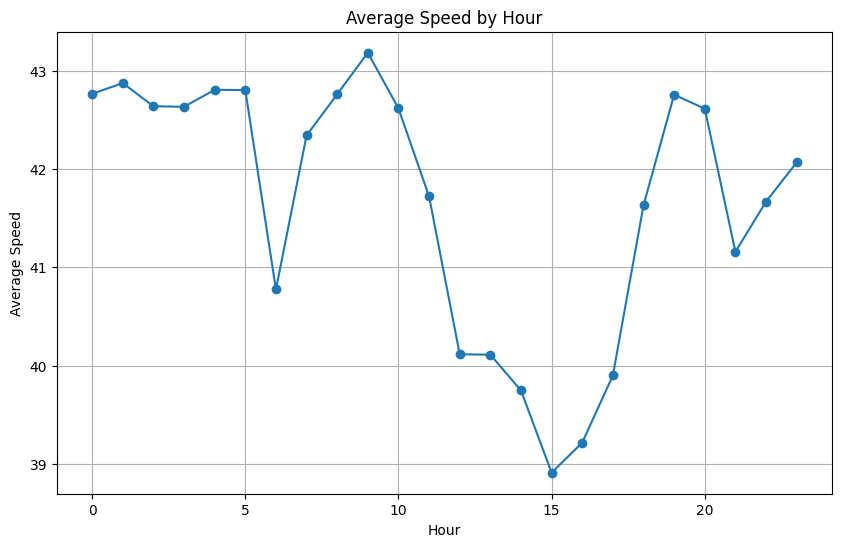

In [28]:
# Convert the Spark dataframe to pandas
avg_speed_by_hour_pd = avg_speed_by_hour.toPandas()

# Order by hour
avg_speed_by_hour_pd = avg_speed_by_hour_pd.sort_values('hour')

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(avg_speed_by_hour_pd['hour'], avg_speed_by_hour_pd['avg_speed'], marker='o')

# Configure the title and tags
plt.title('Average Speed by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Speed')

plt.grid(True)
plt.show()

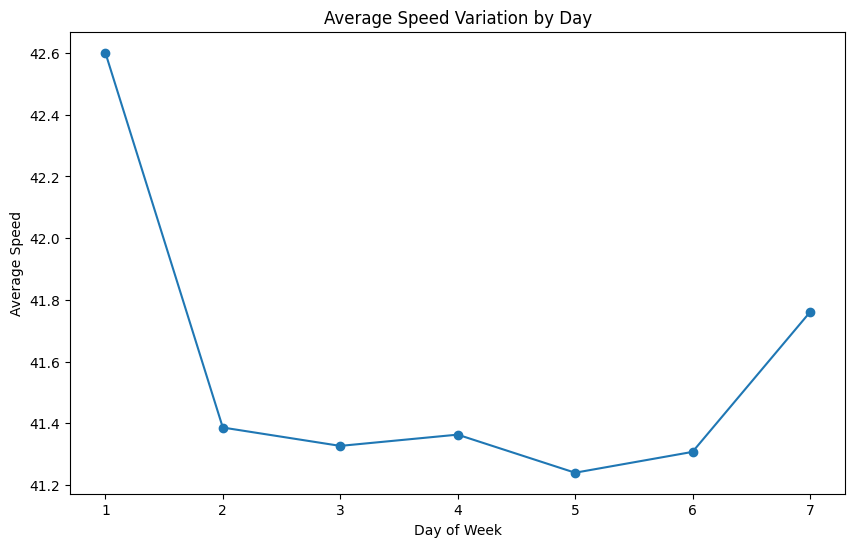

In [29]:
# 4. Patterns or variations by day:
daywise_speed = traffic_data.groupBy('day_of_week').agg({'speed': 'avg'}).toPandas()
daywise_speed = daywise_speed.sort_values('day_of_week')

# Create line chart
plt.figure(figsize=(10, 6))
plt.plot(daywise_speed['day_of_week'], daywise_speed['avg(speed)'], marker='o')

plt.xlabel('Day of Week')
plt.ylabel('Average Speed')
plt.title('Average Speed Variation by Day')
plt.show()

# Predictive Modeling

In [30]:
# 1. Data Preparation
traffic_data_perc = traffic_data_time.groupby('segment_id', 'hour', 'day_of_week', 'month').agg(
                             F.first('estimated_time').alias('estimated_time'),
                             F.expr('percentile(estimated_time, array(0.25))')[0].alias('perc %25'),
                             F.expr('percentile(estimated_time, array(0.50))')[0].alias('perc %50'),
                             F.expr('percentile(estimated_time, array(0.75))')[0].alias('perc %75')
                             )

In [31]:
traffic_data_perc.show(5)

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       141|   0|          1|    1|           1.2|    1.03|    1.11|    1.25|
|       141|   0|          1|    5|          1.76|    1.03|    1.15|     1.3|
|       141|   0|          1|    6|           1.5|    1.03|    1.11|     1.3|
|       141|   0|          2|    2|          1.11|    1.03|    1.11|    1.25|
|       141|   0|          2|   11|          0.97|    1.07|    1.13|     1.3|
+----------+----+-----------+-----+--------------+--------+--------+--------+
only showing top 5 rows



In [32]:
traffic_data_perc[traffic_data_perc['segment_id'] == "143"].show(5)

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       143|   0|          1|    1|          1.03|    1.11|     1.2|    1.36|
|       143|   0|          1|    2|          1.07|    1.11|     1.2|     1.3|
|       143|   0|          1|    3|           1.3|    1.11|     1.2|     1.3|
|       143|   0|          1|    4|          1.67|  1.1875|   1.275|    1.43|
|       143|   0|          1|    5|           1.2|    1.13|     1.2|     1.3|
+----------+----+-----------+-----+--------------+--------+--------+--------+
only showing top 5 rows



In [33]:
traffic_data_perc[traffic_data_perc['estimated_time'] > "1.2"].show(5)

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       141|   0|          1|    5|          1.76|    1.03|    1.15|     1.3|
|       141|   0|          1|    6|           1.5|    1.03|    1.11|     1.3|
|       141|   0|          4|    5|           1.5|    1.03|    1.11|     1.3|
|       141|   0|          6|    1|          1.25|    1.03|    1.11|     1.3|
|       141|   0|          7|    2|          1.25|     1.0|    1.11|     1.2|
+----------+----+-----------+-----+--------------+--------+--------+--------+
only showing top 5 rows



# Search Conditions

In [34]:
# Define search conditions
start_segment = 141
end_segment = 147
hour = 17
day_of_week = 6
month = 3

In [35]:
# Filter the DataFrame based on conditions
filtered_result = traffic_data_perc.filter(
    (col('segment_id').between(start_segment, end_segment)) &
    (col('hour') == hour) &
    (col('day_of_week') == day_of_week) &
    (col('month') == month)
)

In [36]:
filtered_result.show()

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       142|  17|          6|    3|          1.43|    1.11|    1.25|    1.67|
|       144|  17|          6|    3|          1.25|    1.11|    1.25|    1.36|
|       143|  17|          6|    3|          1.25|    1.11|    1.25|    1.43|
|       145|  17|          6|    3|          2.14|    1.07|     1.2|     1.3|
|       141|  17|          6|    3|           1.5|    1.03|    1.11|     1.2|
|       147|  17|          6|    3|           1.3|    1.03|    1.15|  1.2125|
|       146|  17|          6|    3|          0.94|    1.03|    1.15|     1.3|
+----------+----+-----------+-----+--------------+--------+--------+--------+



In [37]:
total_time = filtered_result.agg(F.sum('estimated_time').alias('total_time (min)'))

In [38]:
total_time.show()

+----------------+
|total_time (min)|
+----------------+
|            9.81|
+----------------+



# Predictive Modeling

REGRESION MODEL

In [46]:
traffic_regresion = traffic_data_time.select("segment_id","hour","day_of_week","month","estimated_time")

In [47]:
# Check for null values in 'estimated_time' column
traffic_data_time.select('estimated_time').filter(F.col('estimated_time').isNull() | F.isnan('estimated_time')).count()

0

In [48]:
traffic_regresion.show(10)

+----------+----+-----------+-----+--------------+
|segment_id|hour|day_of_week|month|estimated_time|
+----------+----+-----------+-----+--------------+
|       143|  17|          6|    3|          1.25|
|       143|  18|          6|    3|           1.5|
|       143|  22|          7|    3|          1.15|
|       143|  11|          5|    3|          0.97|
|       143|   7|          7|    3|          1.07|
|       143|  12|          5|    3|          1.67|
|       143|  18|          6|    3|           1.5|
|       143|  18|          6|    3|          1.36|
|       143|  23|          7|    3|          1.11|
|       143|  12|          5|    3|          1.67|
+----------+----+-----------+-----+--------------+
only showing top 10 rows



# Data Preparation

In [50]:
traffic_regresion_grouped_perc = (
    traffic_regresion
    .groupby('segment_id', 'hour', 'day_of_week', 'month')
    .agg(
        F.expr('percentile_approx(estimated_time, 0.5)').alias('q50_estimated_time'),
        F.expr('percentile_approx(estimated_time, 0.25)').alias('q25_estimated_time'),
        F.expr('percentile_approx(estimated_time, 0.75)').alias('q75_estimated_time')
    )
)

In [51]:
traffic_regresion_grouped_perc.show(10)

+----------+----+-----------+-----+------------------+------------------+------------------+
|segment_id|hour|day_of_week|month|q50_estimated_time|q25_estimated_time|q75_estimated_time|
+----------+----+-----------+-----+------------------+------------------+------------------+
|       141|   0|          1|    1|              1.11|              1.03|              1.25|
|       141|   0|          1|    5|              1.15|              1.03|               1.3|
|       141|   0|          1|    6|              1.11|              1.03|               1.3|
|       141|   0|          2|    2|              1.11|              1.03|              1.25|
|       141|   0|          2|   11|              1.11|              1.07|               1.3|
|       141|   0|          3|    1|              1.15|              1.11|               1.3|
|       141|   0|          3|    7|              1.11|              1.03|               1.3|
|       141|   0|          4|    2|              1.11|              0.

In [52]:
traffic_regresion_grouped.show()

+----------+----+-----------+-----+-------------------+
|segment_id|hour|day_of_week|month|mean_estimated_time|
+----------+----+-----------+-----+-------------------+
|       143|   5|          4|    3| 1.1846987951807229|
|       143|  15|          6|    4| 1.4258518518518524|
|       143|  23|          5|    7| 1.2566666666666666|
|       143|   4|          1|    7| 1.2378333333333333|
|       143|   1|          1|    9| 1.2195604395604396|
|       143|  23|          3|   10| 1.2560759493670886|
|       143|  20|          4|   10| 1.1906956521739132|
|       143|   8|          2|    9|  1.177904761904762|
|       143|  15|          1|    1| 1.2446534653465342|
|       143|   7|          6|   12|  1.251573033707865|
|       142|  22|          4|    3|  1.233670886075949|
|       142|   0|          2|    4|  1.181081081081081|
|       142|  12|          2|    6| 1.2264285714285712|
|       142|   8|          2|   10| 1.1513461538461536|
|       142|  10|          5|   10|  1.114234234

# Feature Selection

In [53]:
# Assemble the features into a single vector
vector_assembler_grouped = VectorAssembler(inputCols=["segment_id", "hour", "day_of_week", "month"], outputCol="features")


# Model Training

In [59]:
# 1. Data Transformation
df_assembled_grouped = vector_assembler_grouped.transform(traffic_regresion_grouped_perc)

# Split the data into training and test sets
(train_data_grouped, test_data_grouped) = df_assembled_grouped.randomSplit([0.8, 0.2], seed=42)

In [60]:
# 2. Model Inicialization
# Create the linear regression model
regressor_grouped = LinearRegression(featuresCol="features", labelCol="q50_estimated_time")

In [61]:
# 3. Model Fitting
regressor_grouped = regressor_grouped.fit(train_data_grouped)

In [62]:
# I make predictions on the test set
pred_grouped= regressor_grouped.evaluate(test_data_grouped)

In [63]:
# 4. Model Evaluation
# Root Mean Square Error (RMSE)
eval_grouped = RegressionEvaluator(labelCol="q50_estimated_time", predictionCol="prediction", metricName="rmse")
rmse_grouped = eval_grouped.evaluate(pred_grouped.predictions)
print(f"Root Mean Squared Error (RMSE): {rmse_grouped}")

Root Mean Squared Error (RMSE): 0.21953820297744064


In [64]:
# Mean Absolute Error (MAE)
mae_grouped = eval_grouped.evaluate(pred_grouped.predictions, {eval_grouped.metricName: "mae"})
print("Mean Absolute Error (MAE): %.3f" % mae_grouped)

Mean Absolute Error (MAE): 0.147


In [65]:
# r2 - coefficient of determination
r2_grouped = eval_grouped.evaluate(pred_grouped.predictions, {eval_grouped.metricName: "r2"})
print("coefficient of determination R2: %.3f" %r2_grouped)

coefficient of determination R2: 0.177


In [66]:
# Residuals analysis
residuals_grouped = pred_grouped.predictions.withColumn("residuals", F.col("q50_estimated_time") - F.col("prediction"))

# Visualizing residuals
residuals_pd = residuals_grouped.select("hour", "residuals").toPandas()

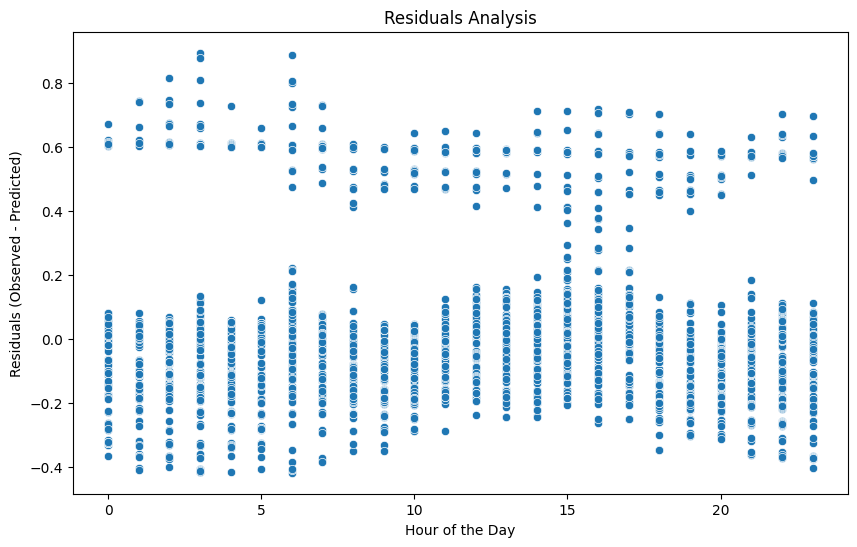

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="hour", y="residuals", data=residuals_pd)
plt.title("Residuals Analysis")
plt.xlabel("Hour of the Day")
plt.ylabel("Residuals (Observed - Predicted)")
plt.show()

# Data Visualization

In [68]:
# Define search conditions
start_segment = 141
end_segment = 147
hour = 17
day_of_week = 6
month = 3

In [69]:
traffic_regresion.show()

+----------+----+-----------+-----+--------------+
|segment_id|hour|day_of_week|month|estimated_time|
+----------+----+-----------+-----+--------------+
|       143|  17|          6|    3|          1.25|
|       143|  18|          6|    3|           1.5|
|       143|  22|          7|    3|          1.15|
|       143|  11|          5|    3|          0.97|
|       143|   7|          7|    3|          1.07|
|       143|  12|          5|    3|          1.67|
|       143|  18|          6|    3|           1.5|
|       143|  18|          6|    3|          1.36|
|       143|  23|          7|    3|          1.11|
|       143|  12|          5|    3|          1.67|
|       143|  18|          6|    3|           1.2|
|       143|   7|          7|    3|          1.67|
|       143|  19|          2|    3|           1.3|
|       143|  15|          5|    3|          1.67|
|       143|   7|          7|    3|          1.03|
|       143|  19|          6|    3|          0.97|
|       143|  13|          5|  

In [70]:
traffic_data_perc = traffic_regresion.groupby('segment_id', 'hour', 'day_of_week', 'month').agg(
                             F.first('estimated_time').alias('estimated_time'),
                             F.expr('percentile(estimated_time, array(0.25))')[0].alias('perc %25'),
                             F.expr('percentile(estimated_time, array(0.50))')[0].alias('perc %50'),
                             F.expr('percentile(estimated_time, array(0.75))')[0].alias('perc %75')
                             )

In [71]:
traffic_data_perc.show()

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       141|   0|          1|    1|           1.2|    1.03|    1.11|    1.25|
|       141|   0|          1|    5|          1.76|    1.03|    1.15|     1.3|
|       141|   0|          1|    6|           1.5|    1.03|    1.11|     1.3|
|       141|   0|          2|    2|          1.11|    1.03|    1.11|    1.25|
|       141|   0|          2|   11|          0.97|    1.07|    1.13|     1.3|
|       141|   0|          3|    1|          1.07|    1.11|    1.15|     1.3|
|       141|   0|          3|    7|          1.03|    1.03|    1.11|     1.3|
|       141|   0|          4|    2|          1.07|    0.97|    1.11|     1.3|
|       141|   0|          4|    5|           1.5|    1.03|    1.11|     1.3|
|       141|   0|          6|    1|          1.25|    1.03|    1

In [73]:
# Filter the DataFrame based on conditions
traffic_regresion_filtered = traffic_data_perc.filter(
    (col('segment_id').between(start_segment, end_segment)) &
    (col('hour') == hour) &
    (col('day_of_week') == day_of_week) &
    (col('month') == month)
)

In [74]:
traffic_regresion_filtered.show()

+----------+----+-----------+-----+--------------+--------+--------+--------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|
+----------+----+-----------+-----+--------------+--------+--------+--------+
|       142|  17|          6|    3|          1.43|    1.11|    1.25|    1.67|
|       144|  17|          6|    3|          1.25|    1.11|    1.25|    1.36|
|       143|  17|          6|    3|          1.25|    1.11|    1.25|    1.43|
|       145|  17|          6|    3|          2.14|    1.07|     1.2|     1.3|
|       141|  17|          6|    3|           1.5|    1.03|    1.11|     1.2|
|       147|  17|          6|    3|           1.3|    1.03|    1.15|  1.2125|
|       146|  17|          6|    3|          0.94|    1.03|    1.15|     1.3|
+----------+----+-----------+-----+--------------+--------+--------+--------+



In [75]:
total_time = traffic_regresion_filtered.agg(F.sum('estimated_time').alias('total_time'))

In [ ]:
total_time.show()

+----------+
|total_time|
+----------+
|      9.81|
+----------+



In [77]:
segment_data = traffic_data.groupBy('segment_id').agg(
    first('start_latitude').alias('start_latitude'),
    first('start_longitude').alias('start_longitude'),
    first('end_latitude').alias('end_latitude'),
    first('end_longitude').alias('end_longitude')
)

segment_data.show()

+----------+--------------+---------------+-------------+--------------+
|segment_id|start_latitude|start_longitude| end_latitude| end_longitude|
+----------+--------------+---------------+-------------+--------------+
|       142| 41.8013192816| -87.6649598466|41.7940254304|-87.6647651619|
|       143| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|
|       144| 41.8158718637| -87.6653316028|41.8086055077|-87.6651559056|
|       141| 41.7940254304| -87.6647651619|41.7867479054|-87.6645778209|
|       145| 41.8231529963| -87.6654916893|41.8158718637|-87.6653316028|
|       150| 41.8668625554| -87.6665671071|41.8577948131|-87.6663216627|
|       148| 41.8523321221| -87.6662077421|41.8376849226|-87.6659250887|
|       146| 41.8305024208| -87.6657517025|41.8231529963|-87.6654916893|
|       147| 41.8376849226| -87.6659250887|41.8305024208|-87.6657517025|
|       149| 41.8577948131| -87.6663216627|41.8523321221|-87.6662077421|
+----------+--------------+---------------+--------

In [78]:
# Join the DataFrames to obtain the start and end coordinates of each segment
joined_df = traffic_regresion_filtered.join(
    segment_data,
    on=['segment_id'],
    how = 'left'
)

joined_df.show()

+----------+----+-----------+-----+--------------+--------+--------+--------+--------------+---------------+-------------+--------------+
|segment_id|hour|day_of_week|month|estimated_time|perc %25|perc %50|perc %75|start_latitude|start_longitude| end_latitude| end_longitude|
+----------+----+-----------+-----+--------------+--------+--------+--------+--------------+---------------+-------------+--------------+
|       142|  17|          6|    3|          1.43|    1.11|    1.25|    1.67| 41.8013192816| -87.6649598466|41.7940254304|-87.6647651619|
|       144|  17|          6|    3|          1.25|    1.11|    1.25|    1.36| 41.8158718637| -87.6653316028|41.8086055077|-87.6651559056|
|       143|  17|          6|    3|          1.25|    1.11|    1.25|    1.43| 41.8086055077| -87.6651559056|41.8013192816|-87.6649598466|
|       145|  17|          6|    3|          2.14|    1.07|     1.2|     1.3| 41.8231529963| -87.6654916893|41.8158718637|-87.6653316028|
|       141|  17|          6|    3

In [79]:
pandas_df = joined_df.toPandas()

pandas_df.head(10)

,segment_id,hour,day_of_week,month,estimated_time,perc %25,perc %50,perc %75,start_latitude,start_longitude,end_latitude,end_longitude
0,142,17,6,3,1.43,1.11,1.25,1.6700,41.801319,-87.664960,41.794025,-87.664765
1,144,17,6,3,1.25,1.11,1.25,1.3600,41.815872,-87.665332,41.808606,-87.665156
2,143,17,6,3,1.25,1.11,1.25,1.4300,41.808606,-87.665156,41.801319,-87.664960
3,145,17,6,3,2.14,1.07,1.20,1.3000,41.823153,-87.665492,41.815872,-87.665332
4,141,17,6,3,1.50,1.03,1.11,1.2000,41.794025,-87.664765,41.786748,-87.664578
5,147,17,6,3,1.30,1.03,1.15,1.2125,41.837685,-87.665925,41.830502,-87.665752
6,146,17,6,3,0.94,1.03,1.15,1.3000,41.830502,-87.665752,41.823153,-87.665492


In [80]:
# Create a map with Folium
map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Get the coordinates of all segments
line_coords = []
for index, row in pandas_df.iterrows():
    line_coords.extend([
        [row['start_latitude'], row['start_longitude']],
        [row['end_latitude'], row['end_longitude']]
    ])

# Add segments to the map with colors based on percentile
for index, row in pandas_df.iterrows():
    if row['estimated_time'] <= row['perc %25']:
        color = 'green'
    elif row['estimated_time'] <= row['perc %50']:
        color = 'yellow'
    elif row['estimated_time'] <= row['perc %75']:
        color = 'orange'
    else:
        color = 'red'

    folium.PolyLine(
        [(row['start_latitude'], row['start_longitude']), (row['end_latitude'], row['end_longitude'])],
        color=color,
        weight=5,
        opacity=1,
        popup=f"Segment ID: {row['segment_id']}, Estimated Time: {row['estimated_time']}"
    ).add_to(map)

# Adjust the zoom to fit the segments
map.fit_bounds([(min([coord[0] for coord in line_coords]), min([coord[1] for coord in line_coords])),
                 (max([coord[0] for coord in line_coords]), max([coord[1] for coord in line_coords]))])

In [81]:
from google.colab import files

# Save the map as an HTML file
map.save("Chicago_Traffic_map.html")

files.download("Chicago_Traffic_map.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>